# 02：MLPによる2クラス分類

---
## 目的
多層パーセプトロン（Multi Layer Perceptron; MLP）を用いて，乳癌データの2クラス分類を行う．
単一サンプルに対するニューラルネットワークの演算と勾配降下法による学習について理解する．

また，オンライン学習，バッチ学習および学習を行う際のiteration, epochについても理解する．

## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## データセットの読み込み
実験に使用するデータセットを読み込みます．

今回は**Breast Cancer Wisconsin Dataset**を用いて2クラス分類を行います．
breast cancer datasetは乳癌のデータセットであり，クラス数は悪性腫瘍 (malignant)と良性腫瘍 (benign) の2クラス，データ数は569（悪性腫瘍 (malignant): 220, 良性腫瘍 (benign): 357）のデータセットです．
各データは細胞核の半径や面積，テクスチャ情報を表現した30次元のベクトルデータです．

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

はじめに，`wget`コマンドを使用して，データセットのファイルをダウンロードします．

次に，データと正解ラベルが含まれている`breast_cancer.csv`を読み込みます．
読み込んだデータのうち，最初の30列に各データを表現した30次元のベクトルデータが格納されており，最後の1列に正解ラベル`(0, 1)`が格納されています．これらをそれぞれ，`x`と`y`に分割して格納します．

In [2]:
# データセットのダウンロード
!wget -q http://www.mprg.cs.chubu.ac.jp/~hirakawa/share/tutorial_data/breast_cancer.csv -O breast_cancer.csv

# データセットの読み込み
breast_cancer_data = np.loadtxt("breast_cancer.csv", dtype=np.float32, delimiter=",")
x = breast_cancer_data[:, :-1]
y = breast_cancer_data[:, -1].astype(np.int32)

print(x.shape, x.dtype)
print(y.shape, y.dtype)

(569, 30) float32
(569,) int32


## データの分割と正規化
上記で読み込んだデータを学習用データとテストデータに分割し，正規化を行います．

データの分割では，`test_sample_ratio`で，テストに用いるサンプルの割合を指定します．
その後，データの総数から，学習とテストにするデータの数を算出し，ランダムにサンプルを振り分けます．
このとき，`np.random.seed`はデータをランダムに分割する際のseedです．
seedを変更，または指定しないことで，無作為にデータを分割することが可能です．

次に正規化を行います．
データ$x$の最小値を$x_{min}$，最大値を$x_{max}$としたとき，次の式で正規化を行います．
$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

`np.min`と`np.max`で学習データの最大，最小値を取得し，上記の式に従い0~1の範囲に値を正規化します．

In [3]:
# データの分割
test_sample_ratio = 0.2  # テストデータの割合を指定
num_data = x.shape[0]    # データの総数
num_test = int(num_data * test_sample_ratio)
num_train = num_data - num_test

np.random.seed(seed=0)
random_index = np.random.permutation(num_data)
x_train = x[random_index[0:num_train]]
y_train = y[random_index[0:num_train]]
x_test = x[random_index[num_train:]]
y_test = y[random_index[num_train:]]

# データの正規化
x_min = np.min(x_train, axis=0)
x_max = np.max(x_train, axis=0)

x_train = (x_train[:, ] - x_min) / (x_max - x_min)
x_test = (x_test[:, ] - x_min) / (x_max - x_min)

## ネットワークモデルの定義
次に，ニューラルネットワーク（多層パーセプトロン）を定義します．

まずはじめに，ネットワークの定義に必要な関数を定義します．

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

上で定義した関数を用いてネットワークモデルを作成します．
ここでは，入力層，中間層，出力層から構成される多層パーセプトロンを定義することとし，1サンプルのデータを入力して結果を出力するようなネットワークを定義します．

入力層と中間層のユニット数は引数として与え，それぞれ`input_size`，`hidden_size`とします．
出力層サイズについては，今回は2クラス分類問題を扱うため，`0~1`でどちらのクラスに属するかを表現するように，ユニット数は1に固定します．
そして，`__init__`関数を用いて，ネットワークのパラメータを初期化します．
`w1`および`w2`は各層の重みで，`b1`および`b2`はバイアスを表しています．
重みは`randn`関数で，標準正規分布に従った乱数で生成した値を保有する配列を生成します．
バイアスは`zeros`関数を用いて，要素が全て0の配列を生成します．

そして，`forward`関数で，データを入力して結果を出力するための演算を定義します．

次に，`backward`関数ではパラメータの更新量を計算します．
まず，ネットワークの出力結果と教師ラベルから，誤差`dy`を算出します．
その後，連鎖律に基づいて，出力層から順番に勾配を計算していきます．
このとき，パラメータの更新量を`self.grads`へ保存しておきます．

また，`update_parameters`関数で，更新量をもとにパラメータの更新を行う関数を定義します．ここでは，`backward`関数によって計算した勾配と更新量（`lr`）によって，現在のパラメータを更新します．

最後に，蓄積している勾配情報を初期化する`clear_grads`関数を定義します．
ここで，`np.zeros_like`関数は引数に入力されたnumpy配列と同じサイズの要素が全て0の配列を作成する関数です．

In [5]:
class MLPBernoulli:
    
    def __init__(self, input_size, hidden_size, w_std=0.01):
        self.w1 = w_std * np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = w_std * np.random.randn(hidden_size, 1)
        self.b2 = np.zeros(1)        
        self.grads = {}

    def forward(self, x):
        self.h1 = np.dot(x, self.w1) + self.b1
        self.h2 = sigmoid(self.h1)
        self.h3 = np.dot(self.h2, self.w2) + self.b2
        self.y = sigmoid(self.h3)
        return self.y

    def backward(self, x, t): 
        self.grads = {}

        dy = (t - self.y)
        d_h3 = sigmoid_grad(self.h3) * dy
        self.grads['w2'] = np.dot(self.h2.T, d_h3)
        self.grads['b2'] = np.sum(d_h3, axis=0)

        d_h2 = np.dot(d_h3, self.w2.T)
        d_h1 = sigmoid_grad(self.h1) * d_h2
        self.grads['w1'] = np.dot(x.T, d_h1)
        self.grads['b1'] = np.sum(d_h1, axis=0)

    def update_parameters(self, lr=0.1):
        self.w1 += lr * self.grads['w1']
        self.b1 += lr * self.grads['b1']
        self.w2 += lr * self.grads['w2']
        self.b2 += lr * self.grads['b2']

## ネットワークの作成と学習の準備
上のプログラムで定義したネットワークを作成します．


まず，中間層と出力層のユニット数を定義します．
ここでは，入力層のユニット数`input_size`を学習データの次元，中間層のユニット数`hidden_size`を64とします．

各層のユニット数を`MLPBernoulli`クラスの引数として与え，ネットワークを作成します．

### ミニバッチ学習で扱うデータ（配列）の形式
作成したネットワークへの入力と出力，教師ラベルのデータ配列のサイズ・形を確認します．
ここでは，上で用意したデータセット（`x_train`, `y_train`）のうち，先頭の10サンプルを`input`, `label`として保存します．
その後，`input`データを`model.forward()`関数に入力し，分類結果を`y`として受け取ります．

**※ ネットワークの学習はまだ行われていないため，分類結果は正しいものとは限らないことに注意してください．**

ここで，入力，出力，教師ラベルの配列サイズを確認します．
入力データは，`(1, 30)`となっており，1次元目がミニバッチサイズに対応しており，2次元目が各サンプルの特徴次元数となっています．
また，出力データのサイズは`(1, 1)`となっており，入力と同様に1次元目がミニバッチサイズ，2次元目は各サンプルの出力次元数となっています．このネットワークでは分類結果を0~1のスコアで出力するため，次元数は1となっています．
また，`y_train`から取り出した教師ラベルのサイズは`(1,)`となっており，1次元の配列（ベクトル）となっています．
学習時の誤差計算に使用するためには，出力データと配列の形を合わせる必要があります．そのために，`reshape()`という関数を適用し，配列の形状を変更することで，対応します．
`reshape(-1, 1)`では，2次元の配列に変更しており，2次元目のサイズを1，1次元目のサイズを-1とすることで任意のサイズに変更します．

In [6]:
input_size = x.shape[1]
hidden_size = 64
model = MLPBernoulli(input_size=input_size, hidden_size=hidden_size)

# 確認用データの準備
input = x_train[0:1]
print("input data shape:", input.shape)

y = model.forward(input)
print("output data shape:", y.shape)

label = y_train[0:1]
print("label data shape:", label.shape)
print("label data shape (reshaped):", label.reshape(-1, 1).shape)

input data shape: (1, 30)
output data shape: (1, 1)
label data shape: (1,)
label data shape (reshaped): (1, 1)


## 1サンプルずつの学習（オンライン学習）
読み込んだbreast cancerデータセットと作成したネットワークを用いて，学習を行います．
ここでは1サンプルずつデータを入力た場合のその出力結果と教師ラベルから誤差を算出し，パラメータの更新を行います．
このように，データセット内のサンプルを一つづつ使用して学習を行う方法を**オンライン学習**と呼びます．

---
### iterationとepoch
ニューラルネットワークの学習を行う際には，学習回数の数え方に**iteration**と**epoch**が存在します．
1回のパラメータ更新は1 iterationであり，データセット内のデータを全て使用して学習した場合に1 epochとなります．
すなわち，iterationは1回のパラメータ更新の単位であり，epochはデータセット1回分の学習を行なった場合の単位です．

今回の実験では，1回の誤差を算出するデータ数は前述したように1，学習エポック数は100エポックとします．
すなわち，1サンプルごとのパラメータ更新を「データセット内のサンプル数$\times$エポック数」分繰り返し学習を行います．

---

上で作成したデータセットを用いて学習を行いますが，学習とテストデータに分割する際にランダムにシャッフルしているため，今回はランダムに並べ替えられたデータを先頭から順番に使用して学習を行います．
各更新において，学習用データと教師データをそれぞれ`input`と`label`とします．
学習モデルに`input`を与えて，分類結果である`y_pred`を取得します．
取得した`y_pred`は精度および誤差を算出するための関数へと入力され，値を保存します．
次に，`clear_grads`で勾配情報を初期化した後，誤差を`backward`関数で逆伝播し，`update_parameters`でネットワークの更新を行います．

In [7]:
# 学習途中の精度を確認するための関数
def binary_classification_accuracy(pred, true):
    pred = pred.flatten()
    clf_res = np.zeros(pred.shape, dtype=np.int32)
    clf_res[pred > 0.5] = 1
    return np.sum(clf_res == true).astype(np.float32)

# 実験用パラメータの設定
num_train_data = x_train.shape[0]
num_test_data = x_test.shape[0]
epoch_num = 100
learning_rate = 0.01

epoch_list = []
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

iteration = 0
for epoch in range(1, epoch_num + 1, 1):
    sum_accuracy = 0.0
    sum_loss = 0.0

    for i in range(0, num_train_data, 1):
        input = x_train[i:i+1]
        label = y_train[i:i+1]

        y_pred = model.forward(input)

        sum_accuracy += binary_classification_accuracy(y_pred, label)
        sum_loss += np.sum(np.power(y_pred - label, 2))

        model.backward(input, label.reshape(-1, 1))
        model.update_parameters(lr=learning_rate)
        
        iteration += 1

    if epoch % 10 == 0:       
        print("epoch: {} (iteration: {}), mean loss: {}, mean accuracy: {}".format(epoch, iteration,
                                                                   sum_loss / num_train_data,
                                                                   sum_accuracy / num_train_data))
    
    test_correct_count = 0
    for i in range(num_test_data):
        input = x_test[i]
        label = y_test[i]
        y = model.forward(input)
        
        if y[0] > 0.5:
            pred = 1
        else:
            pred = 0
        if pred == label:
            test_correct_count += 1

    # 学習途中のlossと精度の保存
    epoch_list.append(epoch)
    train_loss_list.append(sum_loss / num_train_data)
    train_accuracy_list.append(sum_accuracy / num_train_data)
    test_accuracy_list.append(test_correct_count / num_test_data)

epoch: 10 (iteration: 4560), mean loss: 0.23448839542650848, mean accuracy: 0.6293859649122807
epoch: 20 (iteration: 9120), mean loss: 0.23356044759250938, mean accuracy: 0.6293859649122807
epoch: 30 (iteration: 13680), mean loss: 0.23120975436638053, mean accuracy: 0.6293859649122807
epoch: 40 (iteration: 18240), mean loss: 0.22423717018074568, mean accuracy: 0.6293859649122807
epoch: 50 (iteration: 22800), mean loss: 0.20443194531534256, mean accuracy: 0.6403508771929824
epoch: 60 (iteration: 27360), mean loss: 0.16440721701027217, mean accuracy: 0.793859649122807
epoch: 70 (iteration: 31920), mean loss: 0.12167864013240444, mean accuracy: 0.9035087719298246
epoch: 80 (iteration: 36480), mean loss: 0.09387348476072532, mean accuracy: 0.9364035087719298
epoch: 90 (iteration: 41040), mean loss: 0.07775669675392498, mean accuracy: 0.9429824561403509
epoch: 100 (iteration: 45600), mean loss: 0.0677920458135555, mean accuracy: 0.9407894736842105


## テスト
学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

In [8]:
count = 0
num_test_data = x_test.shape[0]

for i in range(num_test_data):
    input = x_test[i]
    label = y_test[i]
    y = model.forward(input)
    
    if y[0] > 0.5:
        pred = 1
    else:
        pred = 0
    
    if pred == label:
        count += 1

print("test accuracy: {}".format(count / num_test_data))

test accuracy: 0.9823008849557522


## 学習推移のグラフ化

上の学習プログラムで保存しておいた誤差および精度のデータをグラフ化します．


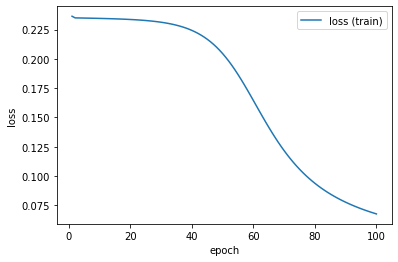

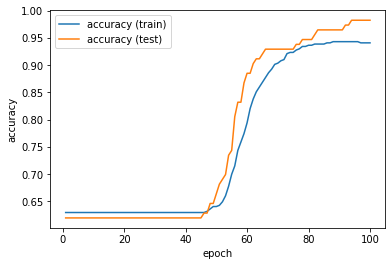

In [9]:
plt.figure()
plt.plot(epoch_list, train_loss_list, label='loss (train)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("loss")      # y軸ラベル
plt.legend()            # 凡例
plt.show()

plt.figure()
plt.plot(epoch_list, train_accuracy_list, label='accuracy (train)')
plt.plot(epoch_list, test_accuracy_list, label='accuracy (test)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.legend()            # 凡例
plt.show()

## 課題
1. 学習率を変更した際の学習の推移を確認してみよう
2. 中間層のサイズを変更した際の精度と学習の推移を比較して考察しよう